# CE-40959: Deep Learning
## HW1
## Q8
#### Name: Pouya khani
#### Student No.: 99210283

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

#### 3.1. Load Data:

Complete the followed cell for data loading. 
In this cell you have to normalize, split and shuffle data for learning.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
    
batch_size_train = 4
batch_size_test =  4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

train_dataset = torchvision.datasets.FashionMNIST('./data',train=True,download=True,
                                                  transform=transform)

test_dataset = torchvision.datasets.FashionMNIST('./data',train=False,download=True,
                                                 transform=transform)

train_subset, val_subset = torch.utils.data.random_split(train_dataset,[50000, 10000], 
                                                         generator=torch.Generator()
                                                         .manual_seed(1))

trainloader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=True, 
                                          batch_size=batch_size_train)
validationloader = torch.utils.data.DataLoader(dataset=val_subset, shuffle=False, 
                                               batch_size=batch_size_test)
testloader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size_test,
                                                             shuffle=False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

100.0%

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


111.0%

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


100.0%

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


159.1%c:\users\pouya\appdata\local\programs\python\python38\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw
Processing...
Done!


#### 3.2. Load Data Test:

In [3]:
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)
print('The size and type of each batch in ''trainloader'' is:')
print(example_data.size())
print(type(example_data))
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)
print('\nThe size and type of each batch in ''testloader'' is:')
print(example_data.size())
print(type(example_data))

The size and type of each batch in trainloader is:
torch.Size([4, 1, 28, 28])
<class 'torch.Tensor'>

The size and type of each batch in testloader is:
torch.Size([4, 1, 28, 28])
<class 'torch.Tensor'>


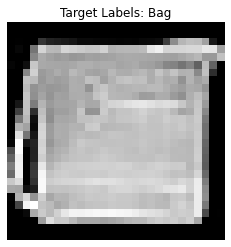

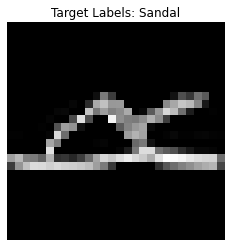

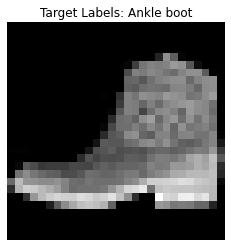

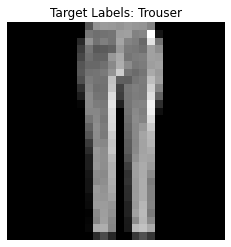

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images:
for i in range(4):
    img=torchvision.utils.make_grid(images[i])
    m=0.5
    s=0.5
    img = img*s + m    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2, 0)))
    plt.title("Target Labels: {}".format(classes[labels[i]]))
    plt.axis('off')
    plt.show()
    

#### 3.3. Network Design:
Design the layer of your network and select proper hyperparameter. 



In [5]:
class MLP(nn.Module):
    def __init__(self, hidden_dim=150, keep_prob = 0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_dim)
        self.fc1_drop = nn.Dropout(keep_prob)
        self.fc3 = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        out = F.log_softmax(self.fc3(x), dim=1)
        return out

#### 3.4. Optimization Algorithm:

In [6]:
net = MLP()
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)

#### 3.5. Training:
You have to tweak `hidden_dim`, `leanirng_rate`, `weight_scale`, `num_epochs` and `reg` and etc to get a validation accuracy above 50%.

In [7]:
num_epochs=2
num_batchs = len(trainloader)
for epoch in range(num_epochs):
    total_train=0
    correct_train=0
    running_loss = 0.0
    for batch, data in enumerate(trainloader, 0):
        inputs, labels = data
        # zero the parameter gradients:
        optimizer.zero_grad()

        # forward pass:
        outputs = net(inputs)

        # backward pass:
        loss = criterion(outputs, labels)
        loss.backward()

        # optimization:
        optimizer.step()

        # Results: 
        running_loss += loss.item()

        total_train += labels.size(0)
        _, predicted_train = torch.max(outputs.data, 1)
        correct_train += (predicted_train == labels.to(device)).sum().item()

        if batch % (num_batchs/10) == ((num_batchs/10) -1):
            print('[Batch %d / %d] loss: %.3f' %
                  (batch + 1, num_batchs, running_loss / (num_batchs/10)))
            running_loss = 0.0
            torch.save(net.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    val_acc = correct / total
    train_acc = correct_train / total_train
    print('(Epoch %d / %d) train acc: %.2f%%; val_acc: %.2f%%' % (
          epoch+1, num_epochs, 100*train_acc, 100*val_acc))

[Batch 1250 / 12500] loss: 0.834
[Batch 2500 / 12500] loss: 0.609
[Batch 3750 / 12500] loss: 0.583
[Batch 5000 / 12500] loss: 0.530
[Batch 6250 / 12500] loss: 0.505
[Batch 7500 / 12500] loss: 0.523
[Batch 8750 / 12500] loss: 0.480
[Batch 10000 / 12500] loss: 0.497
[Batch 11250 / 12500] loss: 0.494
[Batch 12500 / 12500] loss: 0.481
(Epoch 1 / 2) train acc: 79.70%; val_acc: 82.37%
[Batch 1250 / 12500] loss: 0.476
[Batch 2500 / 12500] loss: 0.474
[Batch 3750 / 12500] loss: 0.435
[Batch 5000 / 12500] loss: 0.423
[Batch 6250 / 12500] loss: 0.455
[Batch 7500 / 12500] loss: 0.446
[Batch 8750 / 12500] loss: 0.427
[Batch 10000 / 12500] loss: 0.443
[Batch 11250 / 12500] loss: 0.439
[Batch 12500 / 12500] loss: 0.448
(Epoch 2 / 2) train acc: 83.95%; val_acc: 84.99%


#### 3.6. Test: 
Run the following cell and test your network.

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
test_acc = correct / total
print('Accuracy of the network on the test images: %2f %%' % (100 * test_acc ))

Accuracy of the network on the test images: 84.060000 %


In [9]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.to(device)).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 83 %
Accuracy of Trouser : 96 %
Accuracy of Pullover : 71 %
Accuracy of Dress : 81 %
Accuracy of  Coat : 75 %
Accuracy of Sandal : 91 %
Accuracy of Shirt : 62 %
Accuracy of Sneaker : 89 %
Accuracy of   Bag : 94 %
Accuracy of Ankle boot : 93 %
